In [66]:
import numpy as np
import pandas as pd

In [67]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import splitfolders
import shutil
import cub_dataloader

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [68]:
data = './CUB_200_2011/'
num_classes = 200
num_epochs = 30

feature_extract = True

batch_size = 8

In [69]:
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


In [ ]:
def normalize():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

def denormalize(img):
  imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
  return img*imagenet_stats[1] + imagenet_stats[0]

In [70]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

cub_train = cub_dataloader.Cub2011(data, train=True, transform=data_transforms['train'])
cub_val = cub_dataloader.Cub2011(data, train=False, transform=data_transforms['val'])

# create dataloaders for training and validation
train_loader = torch.utils.data.DataLoader(cub_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(cub_val, batch_size=batch_size, shuffle=False, num_workers=0)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


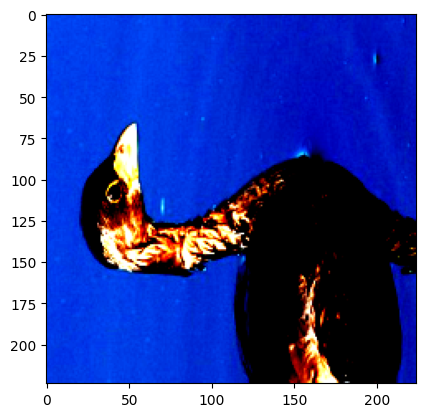

tensor(51)


In [71]:
test_image = next(iter(train_loader))
plt.imshow(test_image[0][0].permute(2, 1, 0))
plt.show()
print(test_image[1][0])

In [72]:
# Feature extracting = True -> requires_grad = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [73]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = None
    input_size = 0
    
    model = models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    
    return model

In [74]:
model = initialize_model(num_classes, feature_extract)

model = model.to(device)

/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
# Gather the parameters to be optimized/updated in this run. If we are
# finetuning we will be updating all parameters. However, if we are
# doing feature extract method, we will only update the parameters
# that we have just initialized, i.e. the parameters with requires_grad
# is True.
params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

# The parameters are optimizing
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

fc.weight
fc.bias


In [76]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [77]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=num_epochs, is_inception=False):
    start = time.time()
    val_acc_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Do this if model is in training phase
            else:
                model.eval()    # Do this if model is in validation phase
                
            running_loss = 0
            running_corrects = 0
            
            # Iteration over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':      # Special case of inception because InceptionV3 has auxillary outputs as well. 
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass and Optimization in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
    time_elapsed = time.time()
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history

In [78]:
model, history = train_model(model, {'train': train_loader, 'val': val_loader}, optimizer, criterion, num_epochs, False)

Epoch 0/29
----------
train Loss: 4.9793 Acc: 0.0460
val Loss: 4.3241 Acc: 0.1500
Epoch 1/29
----------
train Loss: 4.1417 Acc: 0.1757
val Loss: 3.4992 Acc: 0.2974
Epoch 2/29
----------
train Loss: 3.5520 Acc: 0.2819
val Loss: 3.0877 Acc: 0.3887
Epoch 3/29
----------
train Loss: 3.1398 Acc: 0.3594
val Loss: 2.7032 Acc: 0.4061
Epoch 4/29
----------
train Loss: 2.8731 Acc: 0.4082
val Loss: 2.3868 Acc: 0.4617
Epoch 5/29
----------
train Loss: 2.6391 Acc: 0.4506
val Loss: 2.6487 Acc: 0.4588
Epoch 6/29
----------
train Loss: 2.4743 Acc: 0.4775
val Loss: 2.2132 Acc: 0.4941
Epoch 7/29
----------
train Loss: 2.3363 Acc: 0.4997
val Loss: 2.1131 Acc: 0.5036
Epoch 8/29
----------
train Loss: 2.2412 Acc: 0.5219
val Loss: 2.0291 Acc: 0.5228
Epoch 9/29
----------
train Loss: 2.1328 Acc: 0.5417
val Loss: 2.0446 Acc: 0.5340
Epoch 10/29
----------
train Loss: 2.0535 Acc: 0.5519
val Loss: 2.0312 Acc: 0.5292
Epoch 11/29
----------
train Loss: 1.9911 Acc: 0.5549
val Loss: 1.8598 Acc: 0.5425
Epoch 12/29
--

In [79]:
model_nft = initialize_model(num_classes, feature_extract=False)

model_nft = model_nft.to(device)

In [80]:
feature_extract = False
params_to_update = model_nft.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model_nft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model_nft.named_parameters():
        if param.requires_grad:
            print(name)
            
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [81]:
model_nft, history_nft = train_model(model_nft, {'train': train_loader, 'val': val_loader}, optimizer, criterion, num_epochs, False)

Epoch 0/29
----------
train Loss: 4.4213 Acc: 0.1011
val Loss: 2.5524 Acc: 0.3338
Epoch 1/29
----------
train Loss: 2.8057 Acc: 0.3417
val Loss: 1.6832 Acc: 0.5192
Epoch 2/29
----------
train Loss: 2.1318 Acc: 0.4791
val Loss: 1.4384 Acc: 0.5870
Epoch 3/29
----------
train Loss: 1.7457 Acc: 0.5664
val Loss: 1.3351 Acc: 0.6227
Epoch 4/29
----------
train Loss: 1.5580 Acc: 0.6014
val Loss: 1.2540 Acc: 0.6460
Epoch 5/29
----------
train Loss: 1.3834 Acc: 0.6540
val Loss: 1.1334 Acc: 0.6809
Epoch 6/29
----------
train Loss: 1.2637 Acc: 0.6753
val Loss: 1.1743 Acc: 0.6802
Epoch 7/29
----------
train Loss: 1.1807 Acc: 0.7005
val Loss: 1.1939 Acc: 0.6866
Epoch 8/29
----------
train Loss: 1.0870 Acc: 0.7224
val Loss: 1.1792 Acc: 0.6966
Epoch 9/29
----------
train Loss: 1.0376 Acc: 0.7316
val Loss: 1.2483 Acc: 0.6966
Epoch 10/29
----------
train Loss: 1.0230 Acc: 0.7427
val Loss: 1.1636 Acc: 0.6980
Epoch 11/29
----------
train Loss: 0.9509 Acc: 0.7626
val Loss: 1.1700 Acc: 0.7047
Epoch 12/29
--